In [37]:
import os
import time
from datetime import datetime
from functools import cache, wraps
from io import BytesIO
from pathlib import Path
from zipfile import ZipFile

import duckdb
import folium
import httpx
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px


In [2]:
def download_if_outdated(threshold_seconds):
    def decorator(download_func):
        @wraps(download_func)
        def wrapper(*args, **kwargs):
            extract_dir = Path(kwargs.get("extract_dir", "../data/road_traffic_counts_hourly_permanent"))
            # Ensure the directory exists
            extract_dir.mkdir(parents=True, exist_ok=True)

            # Check if the directory is not empty
            if extract_dir.exists() and any(extract_dir.iterdir()):
                now = time.time()

                # Check the age of the first file in the directory
                first_file = next(extract_dir.iterdir())
                file_mod_time = os.path.getmtime(first_file)
                mod_time_datetime = datetime.fromtimestamp(file_mod_time)


                # If the file is newer than the threshold, skip the download
                if now - file_mod_time < threshold_seconds:
                    print(f"Files are up-to-date. Skipping download. Last update: {mod_time_datetime.strftime('%a, %d %b %Y %H:%M:%S')}")
                    return [path.as_posix() for path in extract_dir.glob("*/*.csv")]

            # If the files are older than the threshold, or the directory is empty, call the download function
            return download_func(*args, **kwargs)

        return wrapper

    return decorator

In [3]:
DOWNLOAD_THRESHOLD_DAYS = 2

TABLE_NAME_COUNTS = "road_traffic_counts"
TABLE_NAME_STATIONS = "station_reference"

CSV_FILES_PATH = "../data/road_traffic_counts_hourly_permanent/"

HOURLY_COUNT_ZIP = "https://opendata.transport.nsw.gov.au/dataset/ef2b0bd2-db1e-48f3-9ea1-2bb9e6bc6504/resource/bca06c7e-30be-4a90-bc8b-c67428c0823a/download/road_traffic_counts_hourly_permanent.zip"
STATION_REFERENCE = "https://opendata.transport.nsw.gov.au/dataset/ef2b0bd2-db1e-48f3-9ea1-2bb9e6bc6504/resource/c65ad7b4-0257-4cc6-953e-5299ac8d27ba/download/road_traffic_counts_station_reference.csv"

In [4]:
@download_if_outdated(threshold_seconds=DOWNLOAD_THRESHOLD_DAYS * 24 * 60 * 60)  # 2 days in seconds
def download_extract_hourly_road_count_data():
    extract_dir = Path(CSV_FILES_PATH)
    extract_dir.mkdir(parents=True, exist_ok=True)

    with httpx.Client() as client:
        response = client.get(HOURLY_COUNT_ZIP)

    with ZipFile(BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(extract_dir)

    return [path.as_posix() for path in extract_dir.glob("*/*.csv")]

In [5]:
csv_files = download_extract_hourly_road_count_data()

In [6]:
@cache
def load_data_duckdb():
    con = duckdb.connect()

    con.execute(
        f"CREATE TABLE {TABLE_NAME_STATIONS} AS SELECT * FROM read_csv_auto('{STATION_REFERENCE}')"
    )

    # Assume the first file defines the table structure
    con.execute(f"CREATE TABLE {TABLE_NAME_COUNTS} AS SELECT * FROM read_csv_auto('{csv_files[0]}')")

    # For each subsequent file, insert the data into the existing table
    for csv_file in csv_files[1:]:
        con.execute(f"INSERT INTO {TABLE_NAME_COUNTS} SELECT * FROM read_csv_auto('{csv_file}')")

    df = con.sql(f"SELECT * FROM {TABLE_NAME_COUNTS}").to_df()
    stats = pd.DataFrame(df.describe())
    stats_all = pd.DataFrame(df.describe(include="all"))

    # stats_objects = df.describe(include=[object])
    return df, stats, stats_all, con

In [7]:
df, stats, stats_all, con = load_data_duckdb()

In [8]:
def show_schema(table_name):
    schema = con.execute(f"DESCRIBE {table_name}").fetch_df()
    return schema[["column_name", "column_type", "null"]]

In [9]:
show_schema(TABLE_NAME_COUNTS);

In [10]:
show_schema(TABLE_NAME_STATIONS);

In [11]:
def get_station_details_by_key_or_id(identifier, search_by='key', column=None):
    """
    Fetch station details by station key or station ID.
    
    Parameters:
    - identifier: The station key or station ID to search for.
    - search_by: 'key' to search by station key, 'id' to search by station ID.
    
    Returns:
    - A DataFrame containing the details of the matching station(s).
    """
    if search_by == 'key':
        column_name = 'station_key'
    elif search_by == 'id':
        column_name = 'station_id'
    else:
        raise ValueError("search_by must be either 'key' or 'id'")
    
    query = f"""
        SELECT * FROM {TABLE_NAME_STATIONS}
        WHERE {column_name} = '{identifier}';
    """
    
    station_details_df = con.sql(query).to_df()
    if len(station_details_df) < 1:
        print(f"Station {search_by}: {identifier} doesn't exist")
        return None
    if column is None:
        return station_details_df
    else:
        if column in station_details_df.columns:
            return station_details_df[column].iloc[0]
        return None

In [12]:
# To search by station key:
station_details_by_key = get_station_details_by_key_or_id('99990010', search_by='key', column="name")
station_details_by_key

'Victoria Road'

In [13]:
# To search by station ID:
station_details_by_id = get_station_details_by_key_or_id('56846', search_by='key', column="full_name")
station_details_by_id

'Victoria Road, North of Byrnes Street'

In [14]:
def get_station_full_name(id, search_by='key'):
    return get_station_details_by_key_or_id(id, search_by=search_by, column="full_name")

In [15]:
get_station_full_name("56846")

'Victoria Road, North of Byrnes Street'

In [16]:
def query_station_info(or_like_text=['%Victoria Road%', '%Lyons Road%'], exclude_station_id=["18031", "11139", "19035"]):
    # Convert the list of station IDs to exclude into a SQL-compatible string
    exclude_station_id_sql = ", ".join(f"'{id}'" for id in exclude_station_id)
    
    # Dynamically build the ILIKE conditions based on or_like_text
    like_conditions = " OR ".join([f"full_name ILIKE '{text}'" for text in or_like_text])
    
    # Construct the full SQL query
    station_sql_query = f"""
        SELECT * FROM {TABLE_NAME_STATIONS}
        WHERE ({like_conditions})
        AND station_id NOT IN ({exclude_station_id_sql});
    """
    
    # Execute the query and return the DataFrame
    station_df = con.sql(station_sql_query).to_df()
    return station_df

In [17]:
station_df = query_station_info()
vic_rd_stations = station_df["station_key"].unique().tolist()

In [18]:
result = con.execute(f"SELECT COUNT(*) FROM {TABLE_NAME_COUNTS}").fetchone()

# result now contains the count of rows, which is the first (and only) element in the returned tuple
row_count = result[0]

print(f"Number of rows in {TABLE_NAME_COUNTS}: {row_count}")
assert len(df) == row_count

Number of rows in road_traffic_counts: 3637583


In [34]:
def plot_counts_for_station_key_by_hour_old(station_key, hour, start_year="2023"):
    df = con.sql(
        f"SELECT date, hour_{hour:02}, daily_total FROM {TABLE_NAME_COUNTS} WHERE station_key = {station_key} AND classification_seq = 2 ORDER BY date ASC"
    ).to_df()
    quantile_max = round(df[f"hour_{hour:02}"].quantile(0.999) / 100) * 100  # round to nearest 100
    start_datetime = pd.to_datetime(f"{start_year}-01-01")
    current_date_datetime = pd.to_datetime("now")
    df.plot(
        x="date", y=f"hour_{hour:02}", xlim=[start_datetime, current_date_datetime], ylim=[0, quantile_max], title=f"{get_station_full_name(station_key)}", figsize=(15, 5),
    )
    return df

In [40]:

def plot_counts_for_station_key_by_hour_plotly(station_key, hour, start_year="2023"):
    df = con.sql(
        f"SELECT date, hour_{hour:02} AS traffic_volume, daily_total FROM {TABLE_NAME_COUNTS} WHERE station_key = '{station_key}' AND classification_seq = 2 ORDER BY date ASC"
    ).to_df()
    
    # Convert 'date' column to datetime type for better handling in Plotly
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter data from the start year to the current date
    start_datetime = pd.to_datetime(f"{start_year}-01-01")
    df = df[df['date'] >= start_datetime]
    
    # Plot using Plotly Express
    fig = px.line(df, x='date', y='traffic_volume', title=f"Traffic Counts for Station Key {get_station_full_name(station_key)} at hour {hour}", labels={'traffic_volume': 'Traffic Volume'})
    
    # Enhance the layout
    fig.update_layout(xaxis_title='Date', yaxis_title='Traffic Counts', hovermode='x')
    fig.update_xaxes(rangeslider_visible=True)  # Add a range slider for easy navigation through time
    
    fig.show()

In [41]:
df_all = {}
quantiles = {}
for key in ["99990010", "15286012"]:
    df_all[key] = {} 
    for hour in range(0, 24):
        df_all[key][hour] = plot_counts_for_station_key_by_hour_plotly(key, hour)

In [42]:
def plot_all_hours_for_station_key_plotly(station_key, start_year="2023"):
    # Create a subplot figure with 1 row and 1 column
    fig = make_subplots(rows=1, cols=1)
    
    # Convert start year to datetime for filtering
    start_datetime = pd.to_datetime(f"{start_year}-01-01")
    
    for hour in range(24):
        # Query data for each hour
        df = con.sql(
            f"SELECT date, hour_{hour:02} AS traffic_volume FROM {TABLE_NAME_COUNTS} WHERE station_key = '{station_key}' AND classification_seq = 2 AND date >= '{start_datetime}' ORDER BY date ASC"
        ).to_df()
        
        # Convert 'date' column to datetime type
        df['date'] = pd.to_datetime(df['date'])
        
        # Add a line trace for each hour
        fig.add_trace(
            go.Scatter(x=df['date'], y=df['traffic_volume'], mode='lines', name=f'hour {hour}'),
            row=1, col=1
        )
    
    # Update layout to enhance readability
    fig.update_layout(
        title=f"Traffic Counts for Station Key {get_station_full_name(station_key)} All hours",
        xaxis_title='Date',
        yaxis_title='Traffic Counts',
        hovermode='x'
    )
    
    # Optionally, add a range slider
    fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))
    
    fig.show()

In [43]:
plot_all_hours_for_station_key_plotly("15286012")

In [44]:
def plot_hourly_groups_for_station_key_plotly(station_key, start_year="2023"):
    # Define the hour groups
    hour_groups = [(0, 5), (6, 11), (12, 17), (18, 23)]
    
    # Create a subplot figure with 2 rows and 2 columns
    fig = make_subplots(rows=2, cols=2, subplot_titles=[f"Hours {start}-{end}" for start, end in hour_groups])
    
    # Convert start year to datetime for filtering
    start_datetime = pd.to_datetime(f"{start_year}-01-01")
    
    # Track the current subplot position
    subplot_row = 1
    subplot_col = 1
    
    for start_hour, end_hour in hour_groups:
        for hour in range(start_hour, end_hour + 1):
            # Query data for each hour
            df = con.sql(
                f"SELECT date, hour_{hour:02} AS traffic_volume FROM {TABLE_NAME_COUNTS} WHERE station_key = '{station_key}' AND classification_seq = 2 AND date >= '{start_datetime}' ORDER BY date ASC"
            ).to_df()
            
            # Convert 'date' column to datetime type
            df['date'] = pd.to_datetime(df['date'])
            
            # Add a line trace for this hour to the current subplot
            fig.add_trace(
                go.Scatter(x=df['date'], y=df['traffic_volume'], mode='lines', name=f'hour {hour}'),
                row=subplot_row, col=subplot_col
            )
        
        # Move to the next subplot position
        if subplot_col == 2:
            subplot_row += 1
            subplot_col = 1
        else:
            subplot_col += 1
    
    # Update layout to enhance readability
    fig.update_layout(
        title=f"Traffic Volume for Station Key {get_station_full_name(station_key)} by hourly groups",
        xaxis_title='Date',
        yaxis_title='Traffic Counts',
        hovermode='x'
    )
    
    # Optionally, add a range slider to each subplot
    #fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)), xaxis2=dict(rangeslider=dict(visible=True)), xaxis3=dict(rangeslider=dict(visible=True)), xaxis4=dict(rangeslider=dict(visible=True)))
    
    fig.show()

In [45]:
plot_hourly_groups_for_station_key_plotly("15286012")

In [21]:
# def plotly_hourly_count(df, year_start=year_start_datetime):
#     # Assuming df is your DataFrame and it contains a 'date' column and multiple 'hour_xx' columns

#     df_plot = df.copy()
#     df_plot = df_plot[df_plot["date"] >= year_start]
#     # Create a figure with a slider
#     fig = make_subplots(specs=[[{"secondary_y": True}]])

#     # Add traces for each hour, assuming hours 0 through 23
#     for hour in range(24):
#         fig.add_trace(
#             go.Scatter(x=df["date"], y=df[f"hour_{hour:02}"], name=f"Hour {hour}"),
#             secondary_y=False,
#         )

#     # Create and add slider
#     steps = []
#     for i, hour in enumerate(range(24)):
#         step = dict(method="update", args=[{"visible": [False] * 24}], label=f"Hour {hour}")
#         step["args"][0]["visible"][i] = True  # Toggle i-th trace to "visible"
#         steps.append(step)

#     sliders = [dict(active=0, currentvalue={"prefix": "Hour: "}, pad={"t": 50}, steps=steps)]

#     fig.update_layout(sliders=sliders)
#     return fig

In [22]:
# fig = plotly_hourly_count()
# fig.show()

In [23]:
def plot_counts_for_station_key(station_key):
    # df = con.sql(f"SELECT * FROM {TABLE_NAME_COUNTS} WHERE station_key = {station_key} ORDER BY date").to_df()
    df = con.sql(
        f"SELECT date, daily_total FROM {TABLE_NAME_COUNTS} WHERE station_key = {station_key} AND classification_seq = 2 ORDER BY date ASC"
    ).to_df()
    if len(df) > 0:
        df.plot(x="date", y="daily_total", ylim=[0, 40000], title=f"Station: {get_station_full_name(station_key)}", figsize=(15, 5))
        return df
    else:
        print(f"Station key: {station_key} - {get_station_full_name(station_key)}; no data available")
        return station_key

In [24]:
def plot_daily_counts_all_vic_rd_stations():
    df_all = {}
    station_key_no_data = []
    for station_key in vic_rd_stations:
        result = plot_counts_for_station_key(station_key)
        if isinstance(result, pd.DataFrame):
            df_all[station_key] = result
        else:
            station_key_no_data.append(result)
    return df_all, station_key_no_data

Station key: 56708 - Victoria Road, South of Robert Street; no data available
Station key: 56844 - Victoria Road, South of Burns Bay Road; no data available
Station key: 56853 - Victoria Road, South of Burns Bay Road; no data available
Station key: 57078 - Victoria Road, West of Belmore Lane; no data available
Station key: 56855 - Victoria Road, East of Mortimer Lewis Drive; no data available
Station key: 57058 - Victoria Road, East of Grandview Street; no data available
Station key: 57033 - Victoria Road, West of Sorrell Street; no data available
Station key: 57084 - Victoria Road, West of Hatton Street; no data available
Station key: 57085 - Victoria Road, West of Ryedale Road; no data available
Station key: 57042 - Victoria Road, West of Bridge Street; no data available


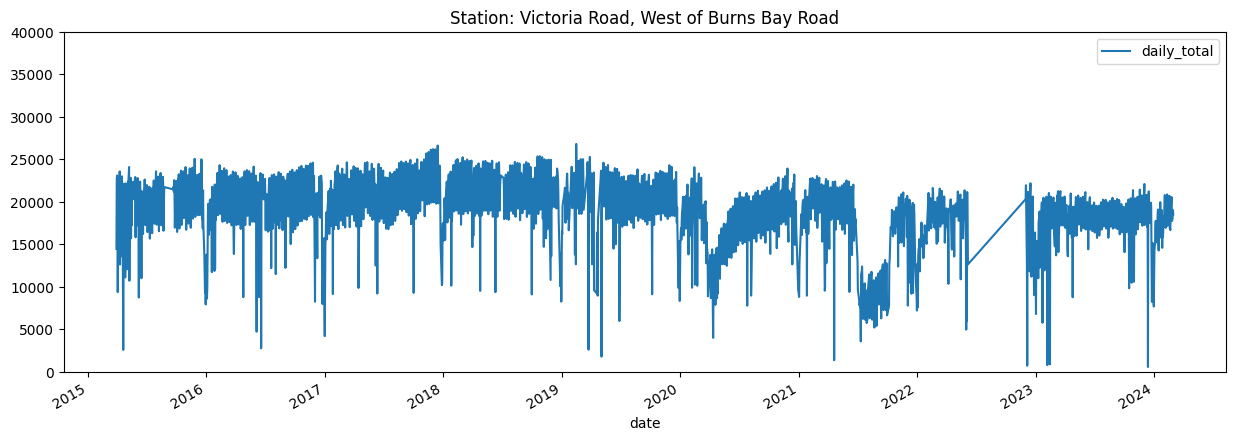

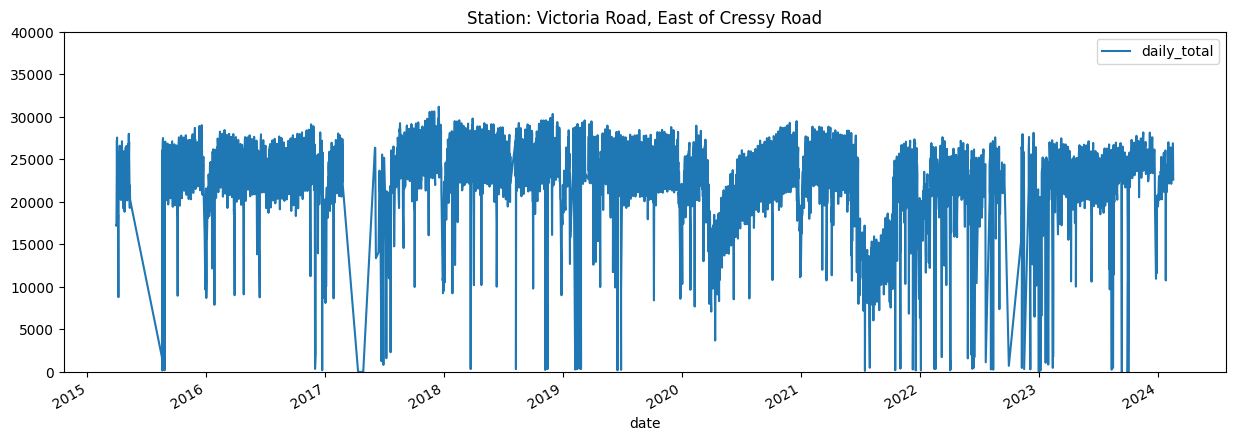

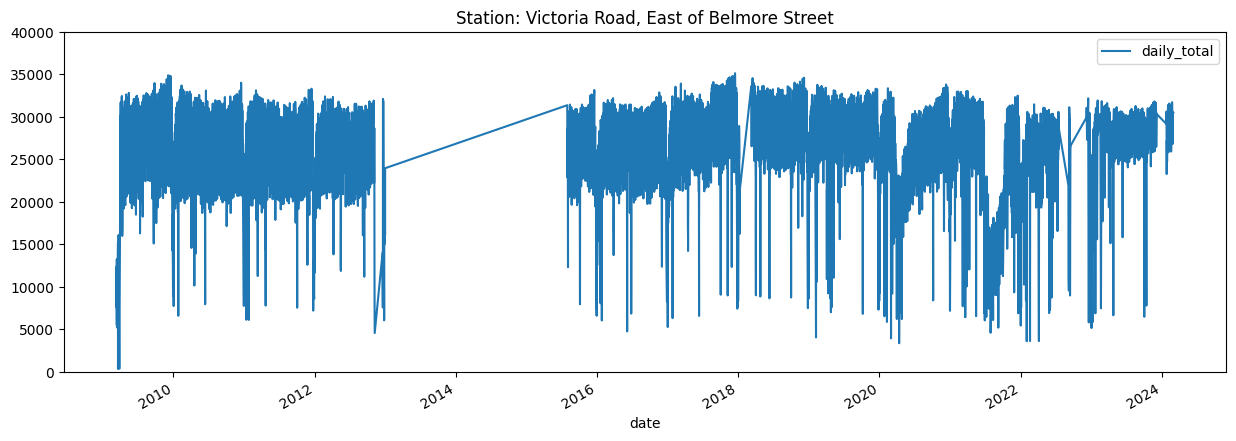

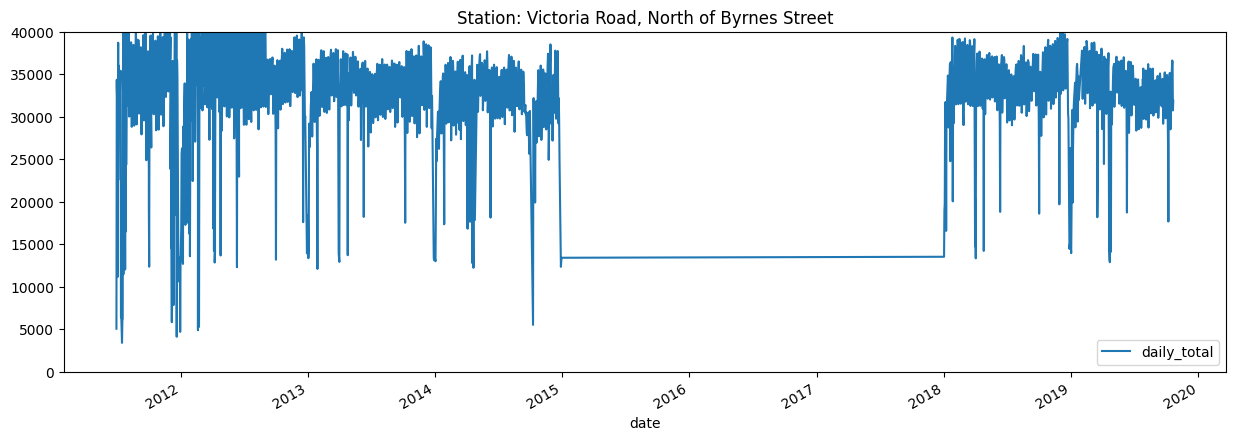

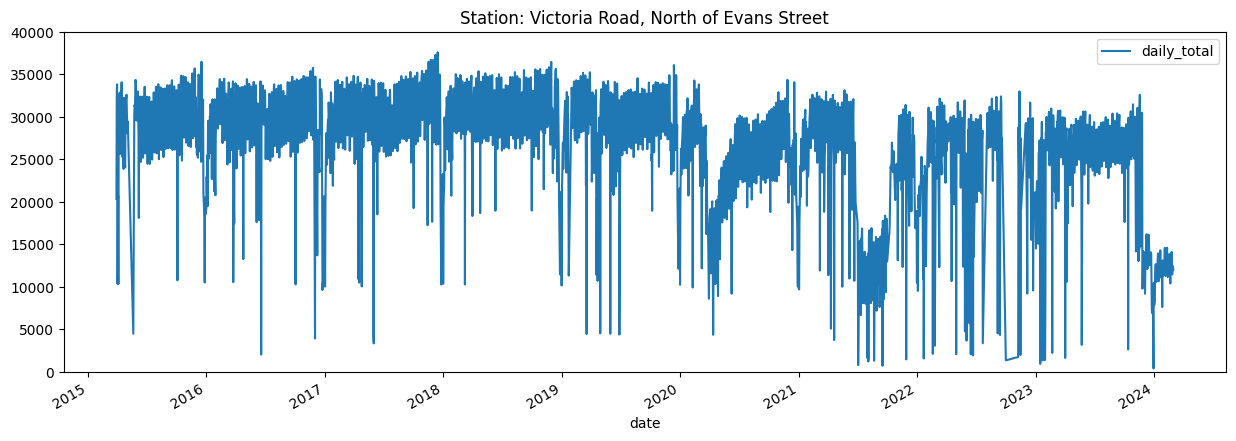

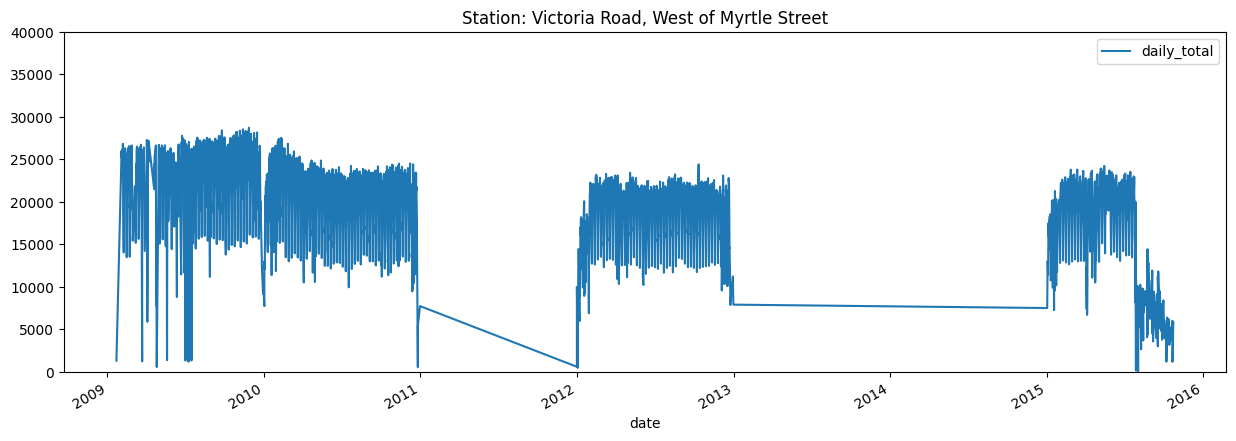

In [25]:
df_all, station_key_no_data = plot_daily_counts_all_vic_rd_stations()

In [26]:
df_all.keys()

dict_keys([15334016, 99990010, 57096, 56846, 15286012, 57050])

In [27]:
def plot_daily_counts_all_vic_rd_stations_one_figure(df_all):
    # Determine the number of subplots needed
    n = len(df_all)
    cols = 3  # Number of columns in the subplot grid
    rows = n // cols + (n % cols > 0)  # Calculate rows needed, round up if there's a remainder

    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5))  # Adjust figsize as needed
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between plots

    # Flatten the array of axes for easy iteration
    axs = axs.ravel()

    for i, (station_key, df) in enumerate(df_all.items()):
        # Assuming 'date' is your x-axis and 'daily_total' is your y-axis
        axs[i].plot(df['date'], df['daily_total'])
        axs[i].set_title(f"{get_station_full_name(station_key)}")
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Daily Count')
        axs[i].tick_params(axis='x', rotation=45)  # Rotate date labels for better readability

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        axs[j].axis('off')

    plt.show()

    

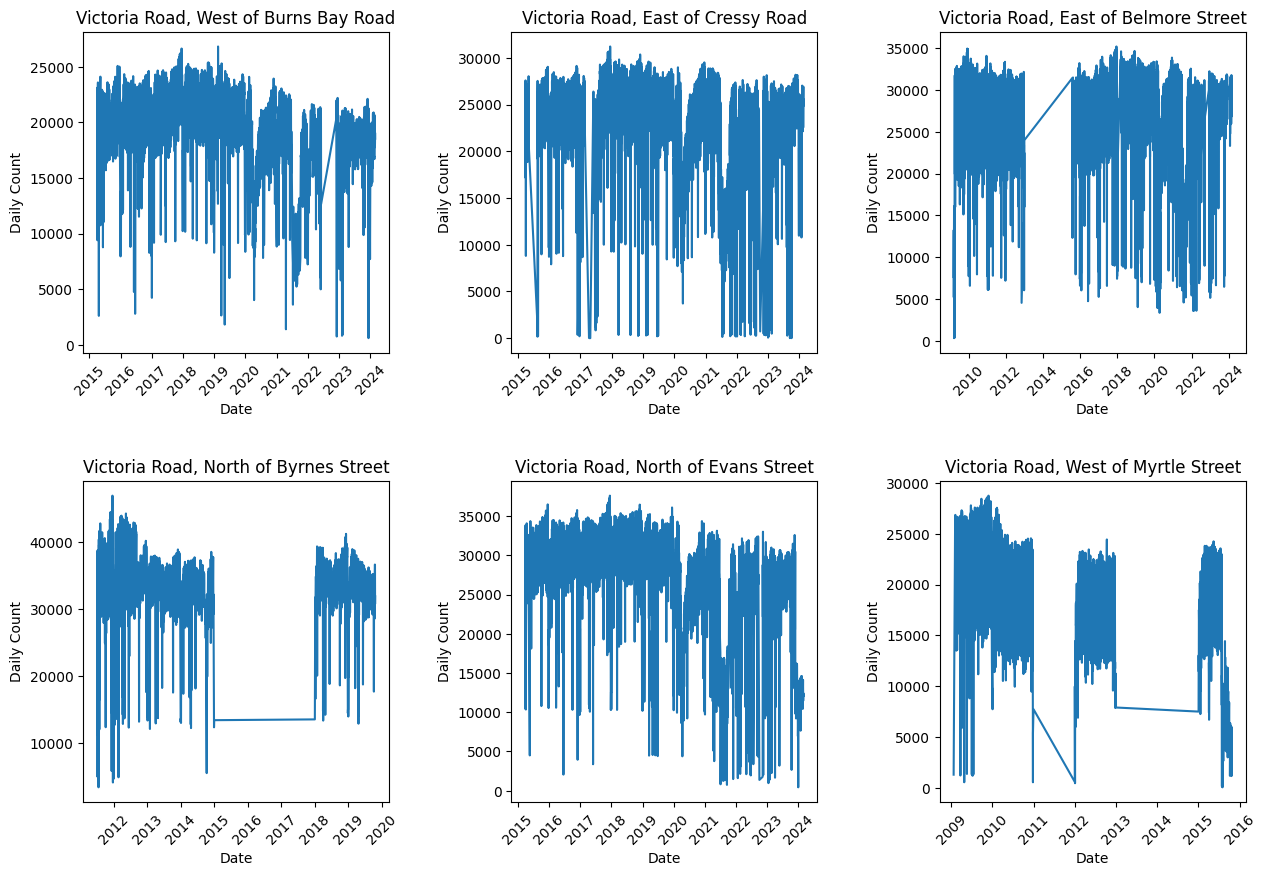

In [28]:
plot_daily_counts_all_vic_rd_stations_one_figure(df_all)

In [29]:
len(df_all)

6

In [30]:
print([table_name[0] for table_name in con.execute("SHOW TABLES;").fetchall()])

['road_traffic_counts', 'station_reference']


In [31]:
def map_selected_stations(station_df):
    # Assuming df has 'wgs84_latitude', 'wgs84_longitude', 'station_id', 'station_key', and 'full_name' columns
    
    m = folium.Map()
    fg = folium.FeatureGroup()  # Create a feature group

    # Add markers to the feature group with popups using itertuples for efficiency
    for row in station_df.itertuples():
        popup_text = f"Station ID (Key): {row.station_id} ({row.station_key})<br>Full Name: {row.full_name}"
        marker = folium.Marker(
            [row.wgs84_latitude, row.wgs84_longitude],
            popup=folium.Popup(popup_text, max_width=450),
        )
        fg.add_child(marker)
    m.add_child(fg)
    m.fit_bounds(fg.get_bounds())
    return m

In [32]:
m = map_selected_stations(station_df)

In [33]:
m